# Product Review Classification based on Sentiment Analysis

In [1]:
# Libraries for Data Analysis
import pandas as pd

# Libraries for Data Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

# Libraries for Modelling and Preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

# Custom Libraries
import data_read
from pre_process import create_reference_label, spacy_preprocess_text, nltk_preprocess_text
from model import run_models

/var/folders/6m/wg76ryq57fnb356nt5xwlbl80000gn/T/ipykernel_58834/3656650360.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package punkt to /Users/vikram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vikram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vikram/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/vikram/nltk_data...
[nltk_data]   Package pu

In [2]:
df = data_read.load_data()

In [3]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,NaN,NaN
1,5.0,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,NaN,NaN
2,5.0,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,NaN,NaN
3,5.0,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,NaN,NaN
4,5.0,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,NaN,NaN


## Data Preprocessing
### 1. Feature Selection

In [4]:
# Dropping other columns as they are not necessary
df = df[['overall', 'summary', 'reviewText']]

### Handling Null values and Duplicates

In [5]:
# Checking for null values in the dataset
print(df.isna().sum())

# Checking for the proportion of null values in the data
print(df.isna().sum().sum()/len(df))

overall        0
summary       15
reviewText    13
dtype: int64
0.0008168504580197211


In [6]:
# Since the proportion of null values are very low, they are dropped.
df = df.dropna()

# Checking again to make sure that there are no null values
df.isna().any()

overall       False
summary       False
reviewText    False
dtype: bool

In [7]:
# Checking for the proportion of duplicated values in the data
len(df[df.duplicated()])/len(df)

0.28505109489051095

In [8]:
# Checking the number of duplicate observations in each star rating
df[df.duplicated()]['overall'].value_counts()

overall
5.0    6840
4.0    1433
3.0     757
1.0     380
2.0     353
Name: count, dtype: int64

In [9]:
# Checking the total values in each star rating - for the purpose of calculating the proportion of duplicates in each class
df['overall'].value_counts()

overall
5.0    19956
4.0     7831
3.0     3880
2.0     1488
1.0     1095
Name: count, dtype: int64

In [10]:
# Positive class (4 and 5 stars) - proportion of duplicates
(6840+1433)/(19956+7831)

0.29772915392089827

In [11]:
# Neutral class (3 stars) - proportion of duplicates
757/3880

0.19510309278350516

In [12]:
# Negative class (1 and 2 stars) - proportion of duplicates
(380 + 353)/(1488 + 1095)

0.283778552071235

Before dropping we have verified that the number of duplicates is almost similar in almost all classes. We consider it similar as for the neutral class, only one star is considered and for positive and negative classes, two star ratings is considered.

In [13]:
# Dropping duplicates
df = df.drop_duplicates()

### 3. Feature Engineering

In [14]:
# Combining Summary and Reviews into one single textual column - text corpus
df['text_corp'] = df['summary'] +" "+ df['reviewText']
df['text_corp'].head()

0    Beautiful Fragrance This handcream has a beaut...
1    wonderful hand lotion wonderful hand lotion, f...
2    Best hand cream around Best hand cream around....
3                                  Five Stars Thanks!!
4    Great hand lotion! Great hand lotion.  Soaks r...
Name: text_corp, dtype: object

In [15]:
# Create the target column
df = create_reference_label(df, rating_col='overall')

In [16]:
df.head()

,overall,summary,reviewText,text_corp,reference_label
0,5.0,Beautiful Fragrance,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance This handcream has a beaut...,1
1,5.0,wonderful hand lotion,"wonderful hand lotion, for seriously dry skin,...","wonderful hand lotion wonderful hand lotion, f...",1
2,5.0,Best hand cream around,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around Best hand cream around....,1
3,5.0,Five Stars,Thanks!!,Five Stars Thanks!!,1
4,5.0,Great hand lotion!,Great hand lotion. Soaks right in and leaves ...,Great hand lotion! Great hand lotion. Soaks r...,1


### 4. Text Cleaning and Lemmatization

* Step 1 : Lowercase and removal of other non-alphanumeric characters
* Step 2 : Remove Stop Words and Punctuation
* Step 3 : Lemmatization

In [17]:
# Creating nltk based pre-processed text column
preproc_df_nltk = nltk_preprocess_text(df, col_name='text_corp', new_col_name='preprocessed_text_nltk')

# Creating spacy based pre-processed text column
preproc_df = spacy_preprocess_text(preproc_df_nltk, col_name='text_corp', new_col_name='preprocessed_text_spacy')

preproc_df.head()

,overall,summary,reviewText,text_corp,reference_label,preprocessed_text_nltk,preprocessed_text_spacy
0,5.0,Beautiful Fragrance,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance This handcream has a beaut...,1,beautiful fragrance this handcream beautiful f...,beautiful fragrance handcream beautiful fragra...
1,5.0,wonderful hand lotion,"wonderful hand lotion, for seriously dry skin,...","wonderful hand lotion wonderful hand lotion, f...",1,wonderful hand lotion wonderful hand lotion se...,wonderful hand lotion wonderful hand lotion se...
2,5.0,Best hand cream around,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around Best hand cream around....,1,best hand cream around best hand cream around ...,best hand cream best hand cream silky thick s...
3,5.0,Five Stars,Thanks!!,Five Stars Thanks!!,1,five stars thanks,stars thanks
4,5.0,Great hand lotion!,Great hand lotion. Soaks right in and leaves ...,Great hand lotion! Great hand lotion. Soaks r...,1,great hand lotion great hand lotion soaks righ...,great hand lotion great hand lotion soaks rig...


## Analysis of Preprocessed data

### 1. Distribution of Word Count

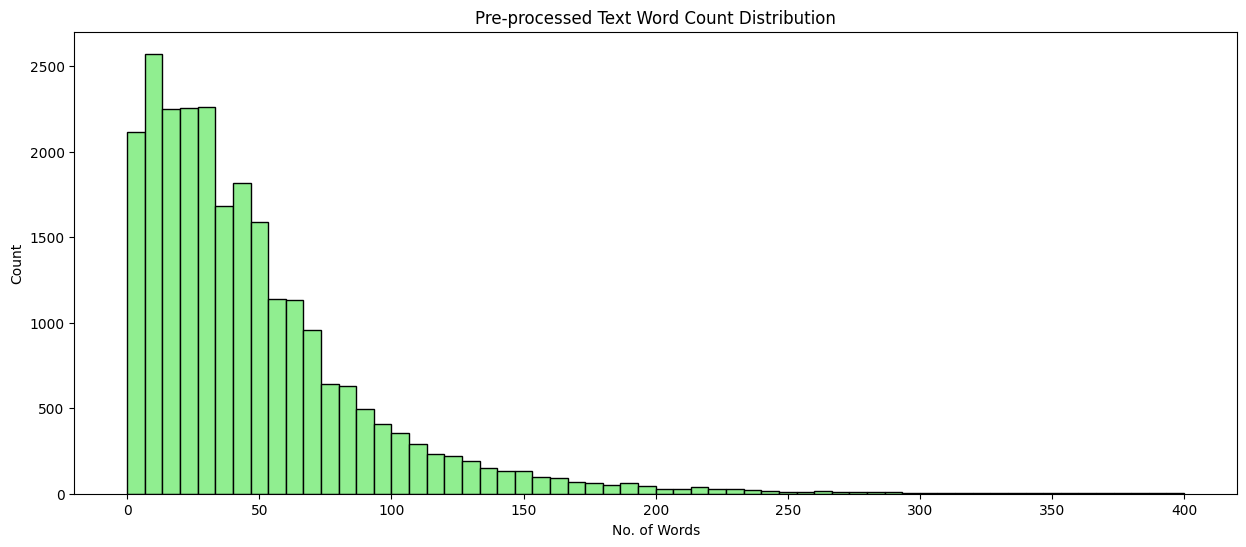

In [18]:
# Function to remove empty reviews if available
def remove_empty_val(l):
    for i in l:
        if(i == ''):
            l.pop(l.index(i))

# Loop to find length of each review and store it in a lst
pre_text_length = []
for i in preproc_df['preprocessed_text_spacy']:
    x1 = i.split(' ')
    remove_empty_val(x1)
    pre_text_length.append(len(x1))
    
# Histogram of word count
fig = plt.figure(figsize = (15, 6))
plt.hist(pre_text_length,bins = 60, range = [0,400], edgecolor = 'black',color = 'lightgreen')
plt.ylabel('Count')
plt.xlabel('No. of Words')
plt.title('Pre-processed Text Word Count Distribution')
plt.show()

The figure above shows a right-skewed distribution, with most of the reviews having a word count between 0 and 200 words, and a smaller tail extending out to reviews with over 400 words.

### 2. Size of Sentiment classes

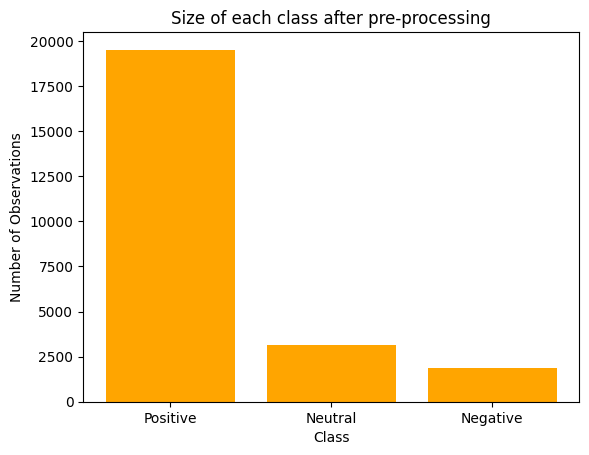

In [19]:
# Dataframe containing the number of samples in each class
size_info_df = preproc_df["reference_label"].value_counts()

# label for class
x_labels = {1:"Positive", 0:"Neutral", -1:"Negative"}

# Plotting a bar plot for visualizing the number of samples in each class
plt.bar(height=size_info_df.values, x=[x_labels.get(i) for i in (size_info_df.index)], color='orange')
plt.xlabel('Class')
plt.ylabel('Number of Observations')
plt.title("Size of each class after pre-processing")
plt.show()

The barchart depicts a clear class imbalance problem in the dataset. The number of positive reviews are high, followed by neutral and then negative reviews

### 3. Word Cloud

*Note: Everytime, Wordcloud creates a new word cloud which might not be the same as the one presented in the report. However, the frequent words do not change.*

In [20]:
# Filtered dataframe for each class
review_pos = preproc_df[preproc_df['reference_label'] == 1].reset_index().drop(columns=['index'])
review_neu = preproc_df[preproc_df['reference_label'] == 0].reset_index().drop(columns=['index'])
review_neg = preproc_df[preproc_df['reference_label'] == -1].reset_index().drop(columns=['index'])

# Choosing spacy pre-processed text for word cloud
s = review_pos['preprocessed_text_spacy']
s1 = review_neu['preprocessed_text_spacy']
s2 = review_neg['preprocessed_text_spacy']

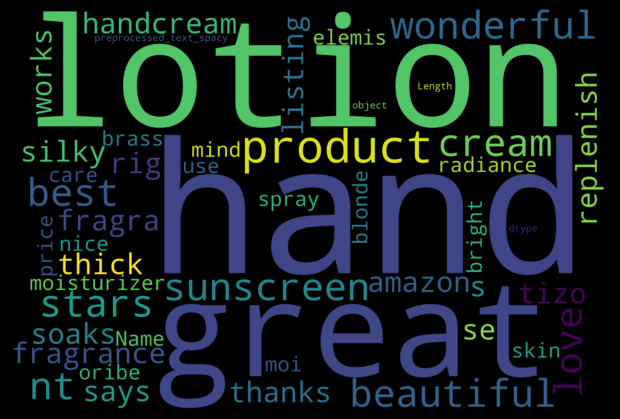

In [21]:
# Positive Reviews
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(s))
fig = plt.figure(
    figsize = (10, 4),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

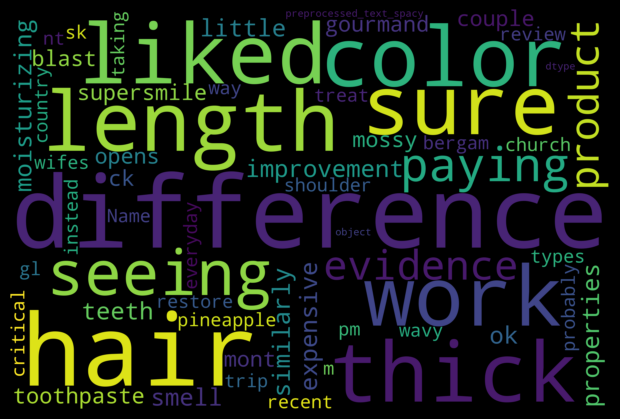

In [22]:
# Neutral Reviews
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(s1))
fig = plt.figure(
    figsize = (10, 4),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

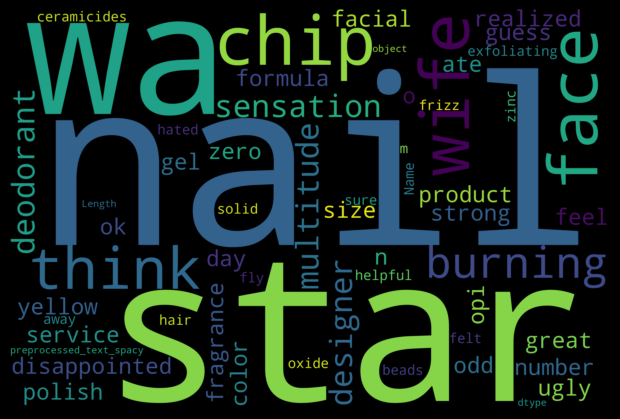

In [23]:
# Negative Reviews
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(s2))
fig = plt.figure(
    figsize = (10, 4),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

From the wordcloud of positive reviews, It is discernible that words like ’hand’, ’lotion’, ’sunscreen’ that do not carry any positive meaning occur quite often. Similarly for neutral and negative reviews, there are certain words like ’nail’, ’chip’, ’thick’, ’hair’, etc., which do not convey any sentiment related information. The weightage to these words can be reduced in the sentiment analysis process by choosing the right vectorization metric

## Vectorization and Modelling

### 1. Instantiating Vectorizer and Models

To vectorize pre-processed text, two methods are considered

* CountVectorizer / Bag of Words
* TF-IDF

In [24]:
# List of Vectorizers
vectorizer_lst = [CountVectorizer(ngram_range=(1,3)), TfidfVectorizer(ngram_range=(1,3))]

# List of models to be used
model_lst = [MultinomialNB(), SGDClassifier(loss='log_loss'), SGDClassifier(loss='hinge')]

# List containgin the names of model and vectorizer - used for creating result dataframe
model_names = [('Naive Bayes', 'Bag of Words'),
               ('Logistic Regression', 'Bag of Words'),
               ('Linear SVM', 'Bag of Words'),
               ('Naive Bayes', 'TF-IDF'),
               ('Logistic Regression', 'TF-IDF'),
               ('Linear SVM', 'TF-IDF'),]

### 2. Solving the class imbalance problem

A combination of undersampling and SMOTE has been used to solve the class imbalance problem.

In [25]:
# Reducing the class size to 50 percentage by generating a random sample for the class with high number of samples.
undersampled_data = preproc_df.drop(preproc_df[preproc_df['reference_label'] == 0].sample(frac=0.50, random_state=42).index)

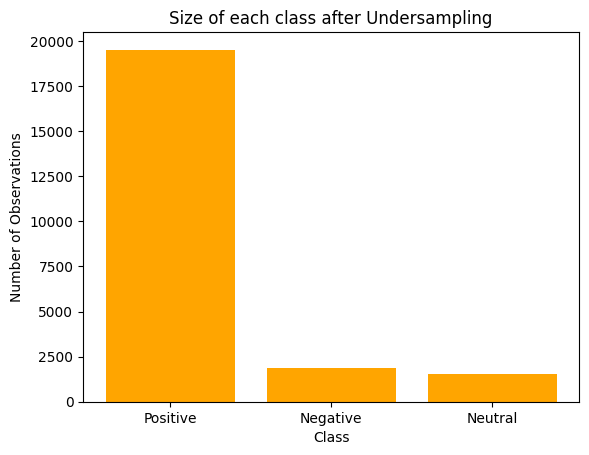

In [26]:
size_info_df = undersampled_data["reference_label"].value_counts()
x_labels = {1:"Positive", 0:"Neutral", -1:"Negative"}

# Bar plot after under-sampling
plt.bar(height=size_info_df.values, x=[x_labels.get(i) for i in (size_info_df.index)], color='orange')
plt.xlabel('Class')
plt.ylabel('Number of Observations')
plt.title("Size of each class after Undersampling")
plt.show()

### 3. Execution of the Pipeline

In [27]:
spacy_results = run_models(df = undersampled_data, model_lst=model_lst, 
                           vectorizer_lst=vectorizer_lst, name_lst=model_names, 
                           pre_processor='spacy', over_sampling=True)

-----------------------------------------------------------------------------------------
Naive Bayes with Bag of Words and spacy
Model Complete
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
Logistic Regression with Bag of Words and spacy
Model Complete
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
Linear SVM with Bag of Words and spacy
Model Complete
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
Naive Bayes with TF-IDF and spacy
Model Complete
-----------------------------------------------------------------------------------------
-----------------------------------------------------------

In [28]:
results = run_models(df = undersampled_data, model_lst=model_lst, 
                     vectorizer_lst=vectorizer_lst, name_lst=model_names, 
                     pre_processor='nltk', over_sampling=True, results=spacy_results)

-----------------------------------------------------------------------------------------
Naive Bayes with Bag of Words and nltk
Model Complete
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
Logistic Regression with Bag of Words and nltk
Model Complete
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
Linear SVM with Bag of Words and nltk
Model Complete
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
Naive Bayes with TF-IDF and nltk
Model Complete
-----------------------------------------------------------------------------------------
---------------------------------------------------------------

In [29]:
final_results_df = pd.DataFrame(results)

In [30]:
final_results_df

,Model,Vectorizer,Preprocessor,Accuracy,Precision,Recall,F1 Score
0,Naive Bayes,Bag of Words,spacy,0.855573,0.819231,0.855573,0.798861
1,Logistic Regression,Bag of Words,spacy,0.817608,0.836332,0.817608,0.826275
2,Linear SVM,Bag of Words,spacy,0.805627,0.832918,0.805627,0.817892
3,Naive Bayes,TF-IDF,spacy,0.721876,0.876955,0.721876,0.777598
4,Logistic Regression,TF-IDF,spacy,0.805700,0.859944,0.805700,0.828025
5,Linear SVM,TF-IDF,spacy,0.872047,0.860601,0.872047,0.865561
6,Naive Bayes,Bag of Words,nltk,0.861810,0.863470,0.861810,0.807923
7,Logistic Regression,Bag of Words,nltk,0.823337,0.841785,0.823337,0.831672
8,Linear SVM,Bag of Words,nltk,0.810876,0.838607,0.810876,0.823164
9,Naive Bayes,TF-IDF,nltk,0.709807,0.890589,0.709807,0.771560


## Conclusion

Based on the results, it was evident that Logistic Regression and Linear Support Vector Machines in combination with TF-IDF vectorization performs well in the task of classifying textual reviews.

Another interesting finding was that all models perform better on NLTK's version of pre-processed data compared to Spacy. The potential reasons for models performing better on NLTK version of data might be due to how these two pre-processers remove stopwords. For example, the word `Five` in a review `Five stars. great!` plays a major role, as it indicates the number of stars and indirectly the emotion. Spacy removes these words, but NLTK does not. Similar to this there are certain stopwords which might carry meaning in the context of this particular dataset for sentiment analysis and Spacy by default removes them. 

In future, better word embedding techniques such as Word2Vec, GloVe and BERT can be used to. These techniques creates word embeddings of shorter and fixed length, which can solve the sparse matrix limitations of the Bag of Words and TF-IDF methods used in this project. Furthermore, since these word embeddings have contextual meanings to them, SMOTE will be able to create better quality synthetic samples which in-turn can improve the performance of machine learning models.